## AST Model with String Classes

### Libraries

In [1]:
import sys
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from transformers import ASTConfig, ASTModel

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import librosa
import noisereduce as nr
import pickle
from moviepy.editor import VideoFileClip

from tqdm.notebook import tqdm


/home/chijuiwu/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Import the MFCC and Spectrogram, Processing

In [2]:
# Load the MFCC dataset
with open('mfcc_dataset_list.pkl', 'rb') as mfcc_file_list:
    mfcc_dataset = pickle.load(mfcc_file_list)


# Load the spectrogram dataset
with open('spectrogram_dataset_list.pkl', 'rb') as spectrogram_file_list:
    spectrogram_dataset = pickle.load(spectrogram_file_list)
    


In [3]:
# Check the dataset shape
print(spectrogram_dataset[0]['spectrogram'])
print(spectrogram_dataset[0]['spectrogram'].shape)

[[-8.287623  -8.287623  -8.287623  ... -2.829914  -2.9057107 -2.9057107]
 [-8.287623  -8.287623  -8.287623  ... -2.9327095 -2.9627967 -2.9627967]
 [-8.287623  -8.287623  -8.287623  ... -3.37057   -3.3034296 -3.3034296]
 ...
 [-8.287623  -8.287623  -8.287623  ... -8.287623  -8.287623  -8.287623 ]
 [-8.287623  -8.287623  -8.287623  ... -8.287623  -8.287623  -8.287623 ]
 [-8.287623  -8.287623  -8.287623  ... -8.281083  -8.2801485 -8.2801485]]
(1024, 128)


In [4]:
# Iterate through each item in the dataset
for item in spectrogram_dataset:
    # Convert the action list to a string
    action_string = ''.join(str(num) for num in item['action'])
    
    # Replace the action list with its string representation
    item['action'] = action_string

# Verify by printing the first few modified items
for item in spectrogram_dataset[:5]:
    print(item)


{'file_id': 'W1XD0EGO', 'sample_rate': 16000, 'start_sec': 0, 'end_sec': 1, 'spectrogram': array([[-8.287623 , -8.287623 , -8.287623 , ..., -2.829914 , -2.9057107,
        -2.9057107],
       [-8.287623 , -8.287623 , -8.287623 , ..., -2.9327095, -2.9627967,
        -2.9627967],
       [-8.287623 , -8.287623 , -8.287623 , ..., -3.37057  , -3.3034296,
        -3.3034296],
       ...,
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.287623 , -8.287623 ,
        -8.287623 ],
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.287623 , -8.287623 ,
        -8.287623 ],
       [-8.287623 , -8.287623 , -8.287623 , ..., -8.281083 , -8.2801485,
        -8.2801485]], dtype=float32), 'action': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000'}
{'file_id': 'W1XD0EGO', 'sample_rate': 16000, 'start_sec': 1, 'end_sec': 2, 'spectrogram': array([[-2.0592518, -2.0592518, -2.00679  , ..., -2.4

In [5]:
# List to hold all action strings for further analysis or use
all_action_strings = []

# Loop through each item in the dataset
for item in spectrogram_dataset:
    # Extract the action list
    action_list = item['action']
    
    # Convert each integer in the list to a string and concatenate them
    action_string = ''.join(str(action) for action in action_list)
    
    # Append the action string to the list
    all_action_strings.append(action_string)
    
print(all_action_strings[:5])

['00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000']


In [6]:
# Dictionary to hold the frequency of each action string
action_string_frequency = {}

# Loop through each action string in all_action_strings
for action_string in all_action_strings:
    if action_string in action_string_frequency:
        action_string_frequency[action_string] += 1
    else:
        action_string_frequency[action_string] = 1

# Print the frequency of each action string
for action_string, count in action_string_frequency.items():
    print(f"Action String: {action_string}, Count: {count}")


Action String: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000001000000010000000000000000000000000000000000, Count: 12
Action String: 00000000000000000000000000000000000000000000000000000000000000000000000000000100000010000000000000000000000000000001000000010000000000000000000000000000000000, Count: 1
Action String: 00000000000000000000000000000000000000000000000000000000000000000000000000000100000010000000000000000000000000000001100000010000000000000000000000000000000000, Count: 2
Action String: 00000000000000000000000000000000000000000000000000000000000000000000000000000100000010100000000000000000000000000001100000010000000000000000000000000000000000, Count: 2
Action String: 00000000000000000000000000000000000000000000000000000000000000000000000000000100000011100000000000000000000000000001100000010000000000000000000000000000000000, Count: 3
Action String: 0000000000000000000000000000000000000000000000000000000000000000

In [7]:
# Convert the list of action strings to a set to remove duplicates
unique_action_strings = set(all_action_strings)

# Print all unique action strings
print("Unique Action Strings:")
for action_string in unique_action_strings:
    print(action_string)

# Optionally, print the count of unique strings
print(f"Total unique action strings: {len(unique_action_strings)}")


Unique Action Strings:
00000000000000000000111000000000000000001000100000000000000000000000000000001001100000000000000001000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100110000000001000000000000000000000000000000000000
00000000000000000000000001101100100000000000000000000000000100000000000000000000000000010000000000000000000000000001000000010000000000000000000000000100100000
00010000000000000000000000000000000000000011100000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
00000000010000000000000000000000000000000000000000000000000001100010000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000
00000011000000010000000000000000000000000000000000000000000000000000000000000000000000011000000000000000000000000000000000000000000000000000110000000000000001
00000100000000000000000

In [8]:
# Convert the set of unique action strings to a sorted list
sorted_unique_action_strings = sorted(unique_action_strings)

# Print sorted unique action strings
print("Sorted Unique Action Strings:")
for action_string in sorted_unique_action_strings:
    print(action_string)

# Optionally, you can again print the count to confirm it remains the same
print(f"Total sorted unique action strings: {len(sorted_unique_action_strings)}")


Sorted Unique Action Strings:
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001001
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010001
0000000000000000

In [9]:
# Check the number of classes
num_classes = len(sorted_unique_action_strings)
print(num_classes)

7664


In [10]:
label_to_int = {label: i for i, label in enumerate(sorted_unique_action_strings)}
print(label_to_int)

{'00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001': 0, '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100': 1, '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101': 2, '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000': 3, '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001001': 4, '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010001': 5, '00000000

In [11]:
print(len(spectrogram_dataset))

23277


### Funtion of Accuracy Calculation

In [12]:
# Define top_k_accuracy function
def top_k_accuracy(logits, labels, k=5):
    sorted_indices = torch.argsort(logits, dim=1, descending=True)
    topk_indices = sorted_indices[:, :k]
    correct = topk_indices == labels.view(-1, 1)
    correct_k = correct.any(dim=1).float().sum().item()
    return correct_k

### Splite the Training, Validation, and Testing

In [13]:
# First split: 80% Train, 20% Temp
train_set, temp_set = train_test_split(
    spectrogram_dataset, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the Temp set into 50% Validation, 50% Test
val_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    random_state=42
)

# Get the number of samples in each set
num_train_samples = len(train_set)
num_val_samples = len(val_set)
num_test_samples = len(test_set)

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of testing samples:", num_test_samples)

Number of training samples: 18621
Number of validation samples: 2328
Number of testing samples: 2328


### Model Config

In [14]:
custom_config = ASTConfig(
    hidden_act="sigmoid", # (str or function, optional, defaults to "gelu") — The non-linear activation function (function or string) in the encoder and pooler. If string, "gelu", "relu", "selu" and "gelu_new" are supported.
    hidden_size=384, # (int, optional, defaults to 768) — Dimensionality of the encoder layers and the pooler layer.
    num_hidden_layers=6, # (int, optional, defaults to 12) — Number of hidden layers in the Transformer encoder.
    num_attention_heads=6, # (int, optional, defaults to 12) — Number of attention heads for each attention layer in the Transformer encoder.
    intermediate_size=3072, # (int, optional, defaults to 3072) — Dimensionality of the “intermediate” (i.e., feed-forward) layer in the Transformer encoder.
    hidden_dropout_prob=0.4, # (float, optional, defaults to 0.0) — The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
    attention_probs_dropout_prob=0.0, # (float, optional, defaults to 0.0) — The dropout ratio for the attention probabilities.
    initializer_range=0.02, # (float, optional, defaults to 0.02) — The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
    layer_norm_eps=1e-12, # (float, optional, defaults to 1e-12) — The epsilon used by the layer normalization layers.
    patch_size=16, # (int, optional, defaults to 16) — The size (resolution) of each patch.
    qkv_bias=True, # (bool, optional, defaults to True) — Whether to add a bias to the queries, keys and values.
    frequency_stride=1, # (int, optional, defaults to 10) — Frequency stride to use when patchifying the spectrograms.
    max_length=32, # (int, optional, defaults to 1024) — Temporal dimension of the spectrograms.
    num_mel_bins=1025, # (int, optional, defaults to 128) — Frequency dimension of the spectrograms (number of Mel-frequency bins).
    time_stride=1, # (int, optional, defaults to 10) — Temporal stride to use when patchifying the spectrograms.
)

In [20]:
configuration = custom_config

model = ASTModel(configuration)

# Accessing the model configuration

configuration = model.config

In [21]:
print(configuration)

ASTConfig {
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 1,
  "hidden_act": "sigmoid",
  "hidden_dropout_prob": 0.4,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 32,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "num_mel_bins": 1025,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 1,
  "transformers_version": "4.32.1"
}



### Model Training Setting

In [22]:
batch_size = 8

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [24]:
model = ASTModel(config=ASTConfig())
final_layer = nn.Linear(384, num_classes)

if torch.cuda.is_available():
    model = model.cuda()
    final_layer = final_layer.cuda()

optimizer = Adam(list(model.parameters()) + list(final_layer.parameters()), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 19.69 MiB is free. Process 3096906 has 1.97 GiB memory in use. Process 2479728 has 10.05 GiB memory in use. Including non-PyTorch memory, this process has 11.62 GiB memory in use. Of the allocated memory 11.26 GiB is allocated by PyTorch, and 63.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Training Process

In [ ]:
num_epochs = 15
num_classes = len(label_to_int)  # Assuming label_to_int is defined

# Initialize dictionaries to track correct and total counts per class for both training and validation
correct_per_class_train = {class_id: 0 for class_id in label_to_int.values()}
total_per_class_train = {class_id: 0 for class_id in label_to_int.values()}
correct_per_class_val = {class_id: 0 for class_id in label_to_int.values()}
total_per_class_val = {class_id: 0 for class_id in label_to_int.values()}

# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_top1_accuracies = []
val_top5_accuracies = []

for epoch in range(num_epochs):
    
    # Initialize accuracy tracking variables
    correct_train = 0
    total_train = 0
    correct_val = 0
    val_top1_correct = 0
    val_top5_correct = 0
    total_val = 0

    # Training phase
    model.train()
    total_train_loss = 0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, mininterval=1)
    for batch in train_progress_bar:
        
        optimizer.zero_grad()
        inputs = batch['spectrogram']
        labels = torch.tensor([label_to_int[label] for label in batch['action']], dtype=torch.long)

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        logits = final_layer(outputs.last_hidden_state[:, 0, :])  # Adjust according to actual output structure
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        

        total_train_loss += loss.item()

        _, predicted = torch.max(logits.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update training per-class accuracy
        for i, label in enumerate(labels.cpu().numpy()):
            total_per_class_train[label] += 1
            if predicted[i] == label:
                correct_per_class_train[label] += 1
        train_progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train
    
    
    # Validation phase
    model.eval()
    total_val_top1_correct = 0
    total_val_top5_correct = 0
    total_val_samples = 0
    total_val_loss = 0
    with torch.no_grad():
        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]", leave=False)
        for batch in val_progress_bar:
            inputs = batch['spectrogram']
            labels = torch.tensor([label_to_int[label] for label in batch['action']], dtype=torch.long)

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            logits = final_layer(outputs.last_hidden_state[:, 0, :])
            val_loss = loss_fn(logits, labels)

            total_val_loss += val_loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Update validation per-class accuracy
            for i, label in enumerate(labels.cpu().numpy()):
                total_per_class_val[label] += 1
                if predicted[i] == label:
                    correct_per_class_val[label] += 1
            val_progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Validate] Loss: {val_loss.item():.4f}")
            
            # Calculate top-k accuracy
            total_val_samples += labels.size(0)
            total_val_top1_correct += top_k_accuracy(logits, labels, k=1)
            total_val_top5_correct += top_k_accuracy(logits, labels, k=5)  
            
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val
    


    # Print training and validation results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    #Top k accuracy
    val_top1_accuracy = total_val_top1_correct / total_val_samples * 100
    val_top5_accuracy = total_val_top5_correct / total_val_samples * 100
    print(f"Validation Top-1 Accuracy: {val_top1_accuracy:.2f}%, Top-5 Accuracy: {val_top5_accuracy:.2f}%")
    

    # Calculate and print per-class accuracies
    for class_id in label_to_int.values():
        class_name = [name for name, id_ in label_to_int.items() if id_ == class_id][0]

        if total_per_class_train[class_id] > 0:
            train_acc = correct_per_class_train[class_id] / total_per_class_train[class_id]
            print(f"Class {class_name} - Train Accuracy: {train_acc:.4f}")

        if total_per_class_val[class_id] > 0:
            val_acc = correct_per_class_val[class_id] / total_per_class_val[class_id]
            print(f"Class {class_name} - Validation Accuracy: {val_acc:.4f}")
    

    # Append loss and accuracy values for this epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)  
    val_top1_accuracies.append(val_top1_accuracy)
    val_top5_accuracies.append(val_top5_accuracy)

### Plotting the Results

ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

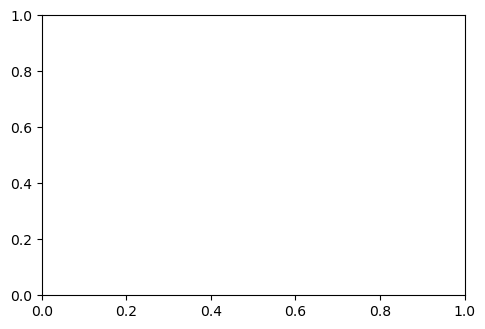

In [25]:
# Plotting
plt.figure(figsize=(12, 8))

# Plot training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), val_top1_accuracies, label='Top-1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Top-1 Accuracy Across Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), val_top5_accuracies, label='Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Top-5 Accuracy Across Epochs')
plt.legend()

plt.tight_layout()
plt.show()